<a href="https://colab.research.google.com/github/FaisalAhmedBijoy/Tensorflow-for-Deep-Learning-Udacity/blob/main/l06c02_exercise_flowers_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c02_exercise_flowers_with_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c02_exercise_flowers_with_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# TensorFlow Hub

[TensorFlow Hub](http://tensorflow.org/hub) is an online repository of already trained TensorFlow models that you can use.
These models can either be used as is, or they can be used for Transfer Learning.

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.

Here, you can see all the models available in [TensorFlow Module Hub](https://tfhub.dev/).

Before starting this Colab, you should reset the Colab environment by selecting `Runtime -> Reset all runtimes...` from menu above.

# Imports


Some normal imports we've seen before. The new one is importing tensorflow_hub which this Colab will make heavy use of.

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# TODO: Download the Flowers Dataset using TensorFlow Datasets

In the cell below you will download the Flowers dataset using TensorFlow Datasets. If you look at the [TensorFlow Datasets documentation](https://www.tensorflow.org/datasets/datasets#tf_flowers) you will see that the name of the Flowers dataset is `tf_flowers`. You can also see that this dataset is only split into a TRAINING set. You will therefore have to use `tfds.splits` to split this training set into to a `training_set` and a `validation_set`. Do a `[70, 30]` split such that 70 corresponds to the `training_set` and 30 to the `validation_set`. Then load the `tf_flowers` dataset using `tfds.load`. Make sure the `tfds.load` function uses the all the parameters you need, and also make sure it returns the dataset info, so we can retrieve information about the datasets.


In [4]:
splits = ['train[:70%]','train[70%:]']

(training_set, validation_set), dataset_info =tfds.load(
    'tf_flowers',
    split=splits,
    with_info=True,
    as_supervised=True
) 

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [7]:
print('Number of training set: ',len(training_set))
print('Number of validation set',len(validation_set))

Number of training set:  2569
Number of validation set 1101


In [9]:
dataset_info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [15]:
dataset_info.features['label']

ClassLabel(shape=(), dtype=tf.int64, num_classes=5)

In [17]:
dataset_info.features['label'].num_classes

5

# TODO: Print Information about the Flowers Dataset

Now that you have downloaded the dataset, use the dataset info to print the number of classes in the dataset, and also write some code that counts how many images we have in the training and validation sets. 

In [19]:
num_classes=dataset_info.features['label'].num_classes
num_training_examples=len(training_set)
num_validation_examples=len(validation_set)
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



The images in the Flowers dataset are not all the same size.

In [20]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


# TODO: Reformat Images and Create Batches

In the cell below create a function that reformats all images to the resolution expected by MobileNet v2 (224, 224) and normalizes them. The function should take in an `image` and a `label` as arguments and should return the new `image` and corresponding `label`. Then create training and validation batches of size `32`.

In [27]:
IMAGE_RES = 224

def format_image(image, label):
  image=tf.image.resize(image,(IMAGE_RES,IMAGE_RES))/255.0
  
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [28]:
train_batches

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [29]:
validation_batches

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

# Do Simple Transfer Learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning. Remember, in transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

### TODO: Create a Feature Extractor
In the cell below create a `feature_extractor` using MobileNet v2. Remember that the partial model from TensorFlow Hub (without the final classification layer) is called a feature vector. Go to the [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) to see a list of available feature vectors. Click on the `tf2-preview/mobilenet_v2/feature_vector`. Read the documentation and get the corresponding `URL` to get the MobileNet v2 feature vector. Finally, create a `feature_extractor` by using `hub.KerasLayer` with the correct `input_shape` parameter.

In [30]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'
feature_extractor = hub.KerasLayer(URL,input_shape=(IMAGE_RES,IMAGE_RES,3))

In [35]:
feature_extractor.compute_dtype

'float32'

### TODO: Freeze the Pre-Trained Model

In the cell below freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [37]:
feature_extractor.trainable=False

### TODO: Attach a classification head

In the cell below create a `tf.keras.Sequential` model, and add the pre-trained model and the new classification layer. Remember that the classification layer must have the same number of classes as our Flowers dataset. Finally print a summary of the Sequential model.

In [38]:
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(num_classes)
])


In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
_________________________________________________________________
dense (Dense)                (None, 5)                 5010      
Total params: 3,545,275
Trainable params: 5,010
Non-trainable params: 3,540,265
_________________________________________________________________


### TODO: Train the model

In the cell bellow train this model like any other, by first calling `compile` and then followed by `fit`. Make sure you use the proper parameters when applying both methods. Train the model for only 6 epochs.

In [41]:
model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [42]:
EPOCHS=6
history =model.fit(train_batches,epochs=EPOCHS,validation_data=validation_batches)



Epoch 1/6
81/81 [==============================] - 15s 73ms/step - loss: 1.3947 - accuracy: 0.5303 - val_loss: 0.4628 - val_accuracy: 0.8411
Epoch 2/6
81/81 [==============================] - 3s 42ms/step - loss: 0.3952 - accuracy: 0.8519 - val_loss: 0.3859 - val_accuracy: 0.8774
Epoch 3/6
81/81 [==============================] - 3s 42ms/step - loss: 0.2948 - accuracy: 0.8996 - val_loss: 0.3673 - val_accuracy: 0.8765
Epoch 4/6
81/81 [==============================] - 3s 42ms/step - loss: 0.2624 - accuracy: 0.9106 - val_loss: 0.3613 - val_accuracy: 0.8792
Epoch 5/6
81/81 [==============================] - 3s 42ms/step - loss: 0.2165 - accuracy: 0.9377 - val_loss: 0.3592 - val_accuracy: 0.8783
Epoch 6/6
81/81 [==============================] - 3s 42ms/step - loss: 0.1894 - accuracy: 0.9438 - val_loss: 0.3531 - val_accuracy: 0.8810


You can see we get ~88% validation accuracy with only 6 epochs of training, which is absolutely awesome. This is a huge improvement over the model we created in the previous lesson, where we were able to get ~76% accuracy with 80 epochs of training. The reason for this difference is that MobileNet v2 was carefully designed over a long time by experts, then trained on a massive dataset (ImageNet).

# TODO: Plot Training and Validation Graphs

In the cell below, plot the training and validation accuracy/loss graphs.

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)


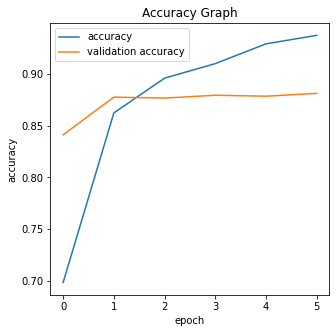

In [48]:
plt.figure(figsize=(5,5))
plt.plot(epochs_range,acc,label='accuracy')
plt.plot(epochs_range,val_acc,label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

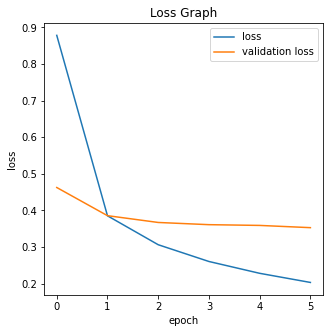

In [49]:
plt.figure(figsize=(5,5))
plt.plot(epochs_range,loss,label='loss')
plt.plot(epochs_range,val_loss,label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Flower images. 

# TODO: Check Predictions

In the cell below get the label names from the dataset info and convert them into a NumPy array. Print the array to make sure you have the correct label names.

In [54]:
dataset_info.features['label']

ClassLabel(shape=(), dtype=tf.int64, num_classes=5)

In [56]:
print(dataset_info.features['label'].names)
class_names = np.array(dataset_info.features['label'].names)
print(class_names)


['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


### TODO: Create an Image Batch and Make Predictions

In the cell below, use the `next()` function to create an `image_batch` and its corresponding `label_batch`. Convert both the `image_batch` and `label_batch` to numpy arrays using the `.numpy()` method. Then use the `.predict()` method to run the image batch through your model and make predictions. Then use the `np.argmax()` function to get the indices of the best prediction for each image. Finally convert the indices of the best predictions to class names.

In [57]:
image_batch, label_batch = next(iter(train_batches))

image_batch=image_batch.numpy()
label_batch=label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch,axis=-1)
predicted_class_names = class_names[predicted_ids]


### TODO: Print True Labels and Predicted Indices

In the cell below, print the true labels and the indices of predicted labels.

In [58]:
print('Labels: ',label_batch)
print('Predicted labels: ',predicted_ids)

Labels:  [2 0 0 2 1 1 3 2 4 2 1 2 2 0 2 2 0 2 0 0 4 2 2 3 2 4 3 1 0 2 4 3]
Predicted labels:  [2 0 0 2 1 1 3 2 4 2 1 2 2 0 2 2 0 2 0 0 4 2 2 3 2 4 3 1 0 2 4 3]


In [59]:
predicted_class_names

array(['tulips', 'dandelion', 'dandelion', 'tulips', 'daisy', 'daisy',
       'sunflowers', 'tulips', 'roses', 'tulips', 'daisy', 'tulips',
       'tulips', 'dandelion', 'tulips', 'tulips', 'dandelion', 'tulips',
       'dandelion', 'dandelion', 'roses', 'tulips', 'tulips',
       'sunflowers', 'tulips', 'roses', 'sunflowers', 'daisy',
       'dandelion', 'tulips', 'roses', 'sunflowers'], dtype='<U10')

# Plot Model Predictions

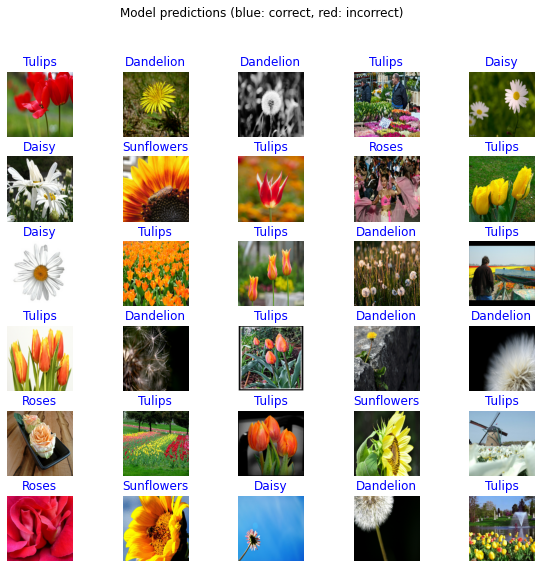

In [60]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# TODO: Perform Transfer Learning with the Inception Model

Go to the [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) and click on `tf2-preview/inception_v3/feature_vector`. This feature vector corresponds to the Inception v3 model. In the cells below, use transfer learning to create a CNN that uses Inception v3 as the pretrained model to classify the images from the Flowers dataset. Note that Inception, takes as input, images that are 299 x 299 pixels. Compare the accuracy you get with Inception v3 to the accuracy you got with MobileNet v2.

In [61]:
inception_v2_input_shape=299

In [62]:
URL='https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'
feature_extractor_inception_v3=hub.KerasLayer(URL,input_shape=(inception_v2_input_shape,inception_v2_input_shape,3))

In [63]:
feature_extractor_inception_v3.trainable=False

In [64]:
model_inception_v3=tf.keras.Sequential([
                                        feature_extractor_inception_v3,
                                        layers.Dense(num_classes)
])

In [65]:
model_inception_v3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              23853833  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5010      
Total params: 23,858,843
Trainable params: 5,010
Non-trainable params: 23,853,833
_________________________________________________________________


In [66]:
model_inception_v3.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [67]:
history=model_inception_v3.fit(train_batches,epochs=EPOCHS,validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 10s 78ms/step - loss: 1.8604 - accuracy: 0.4811 - val_loss: 0.5880 - val_accuracy: 0.7920
Epoch 2/6
81/81 [==============================] - 5s 64ms/step - loss: 0.5560 - accuracy: 0.8120 - val_loss: 0.4957 - val_accuracy: 0.8283
Epoch 3/6
81/81 [==============================] - 5s 64ms/step - loss: 0.4028 - accuracy: 0.8558 - val_loss: 0.4532 - val_accuracy: 0.8456
Epoch 4/6
81/81 [==============================] - 5s 64ms/step - loss: 0.3156 - accuracy: 0.8872 - val_loss: 0.4375 - val_accuracy: 0.8520
Epoch 5/6
81/81 [==============================] - 5s 64ms/step - loss: 0.2781 - accuracy: 0.9083 - val_loss: 0.4272 - val_accuracy: 0.8601
Epoch 6/6
81/81 [==============================] - 5s 64ms/step - loss: 0.2576 - accuracy: 0.9168 - val_loss: 0.4156 - val_accuracy: 0.8592


In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)


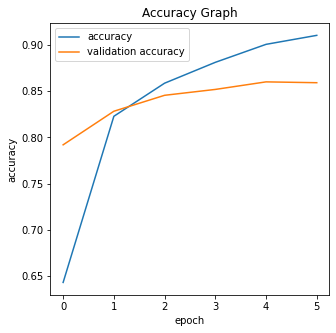

In [69]:
plt.figure(figsize=(5,5))
plt.plot(epochs_range,acc,label='accuracy')
plt.plot(epochs_range,val_acc,label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

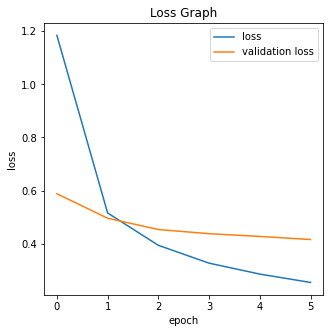

In [70]:
plt.figure(figsize=(5,5))
plt.plot(epochs_range,loss,label='loss')
plt.plot(epochs_range,val_loss,label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [71]:
image_batch, label_batch = next(iter(train_batches))

image_batch=image_batch.numpy()
label_batch=label_batch.numpy()

predicted_batch = model_inception_v3.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch,axis=-1)
predicted_class_names = class_names[predicted_ids]


In [72]:
print('Labels: ',label_batch)
print('Predicted labels: ',predicted_ids)

Labels:  [0 2 1 4 0 0 4 1 4 4 4 0 4 2 0 2 3 4 4 1 0 0 2 3 3 1 2 0 4 0 1 1]
Predicted labels:  [0 2 1 4 0 0 4 1 4 4 4 0 4 2 0 2 3 4 4 1 0 0 2 3 3 1 2 0 0 0 1 1]


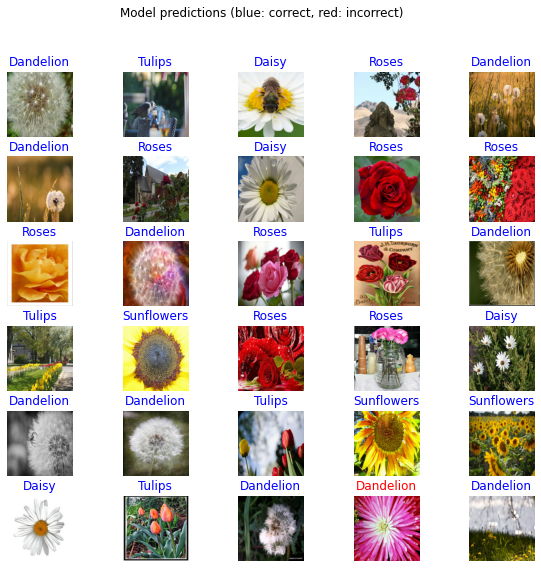

In [73]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

## Comparision Analysis of Inception v3 and MobileNet v2

- accuracy of inception v3 is less than 90 %
- accuracy of mobilenet v2 is upper than 95 %

we can conclude that mobilenet v2 is perform well rather than inception v3 in this flower dataset 